In [4]:
import pandas as pd

df = pd.read_csv('../../data/pl_final.csv')

In [5]:
df = df.sort_values('date')

df['home_xG_rolling'] = (
    df.groupby('home_team')['xG'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['away_xG_rolling'] = (
    df.groupby('away_team')['xG.1'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['xG_diff_rolling'] = df['home_xG_rolling'] - df['away_xG_rolling']

df['elo_diff'] = df['home_elo_before'] - df['away_elo_before']

df['goals_diff_rolling'] = df['home_goals_scored_rolling'] - df['away_goals_scored_rolling']
df['conceded_diff_rolling'] = df['home_goals_conceded_rolling'] - df['away_goals_conceded_rolling']

In [6]:
df.dropna(inplace=True, axis=0)
df.columns

Index(['date', 'home_team', 'away_team', 'result', 'odds_home_win',
       'odds_draw', 'odds_away_win', 'home_goals_scored_rolling',
       'home_goals_conceded_rolling', 'home_shots_rolling',
       'home_shots_on_target_rolling', 'home_fouls_rolling',
       'home_corners_rolling', 'home_yellow_cards_rolling',
       'home_red_cards_rolling', 'away_goals_scored_rolling',
       'away_goals_conceded_rolling', 'away_shots_rolling',
       'away_shots_on_target_rolling', 'away_fouls_rolling',
       'away_corners_rolling', 'away_yellow_cards_rolling',
       'away_red_cards_rolling', 'home_elo_before', 'away_elo_before',
       'prob_home', 'prob_draw', 'prob_away', 'xG', 'xG.1', 'home_xG_rolling',
       'away_xG_rolling', 'xG_diff_rolling', 'elo_diff', 'goals_diff_rolling',
       'conceded_diff_rolling'],
      dtype='object')

In [4]:
# df = df[df['date'] >= '2025-08-01']

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
df = df.sort_values('date')

In [9]:
X = df.drop(columns=['result', 'date', 'xG', 'xG.1', 'home_red_cards_rolling', 'away_red_cards_rolling', 'home_team', 'away_team'])
y = df['result']

In [10]:
X.columns

Index(['odds_home_win', 'odds_draw', 'odds_away_win',
       'home_goals_scored_rolling', 'home_goals_conceded_rolling',
       'home_shots_rolling', 'home_shots_on_target_rolling',
       'home_fouls_rolling', 'home_corners_rolling',
       'home_yellow_cards_rolling', 'away_goals_scored_rolling',
       'away_goals_conceded_rolling', 'away_shots_rolling',
       'away_shots_on_target_rolling', 'away_fouls_rolling',
       'away_corners_rolling', 'away_yellow_cards_rolling', 'home_elo_before',
       'away_elo_before', 'prob_home', 'prob_draw', 'prob_away',
       'home_xG_rolling', 'away_xG_rolling', 'xG_diff_rolling', 'elo_diff',
       'goals_diff_rolling', 'conceded_diff_rolling'],
      dtype='object')

In [9]:
tscv = TimeSeriesSplit(n_splits=10)
rf_importances = []

In [10]:
def multiclass_brier_score(y_true, y_prob):
    """
    Computes the multiclass Brier score (the mean squared error between
    one-hot labels and predicted probabilities).
    """
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]  # One-hot encode labels
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1)) / n_classes

def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    # --- Metrics ---
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    ll = log_loss(y_test, probs)

    # Correct multiclass Brier score
    brier = multiclass_brier_score(y_test.to_numpy(), probs)


    print(f"\n=== {name} ===")
    print('accuracy:', acc)
    print('precision:', prec)
    print('recall:', rec)
    print('f1 score:', f1)
    print('log loss:', ll)
    print('brier score:', brier)

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(
        y_test, preds, 
        target_names=["Draw", "Away", "Home"],
        zero_division=0
    ))

    # # --- Confusion Matrix ---
    # cm = confusion_matrix(y_test, preds)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(
    #     cm, annot=True, fmt='d',
    #     xticklabels=["Draw", "Away", "Home"],
    #     yticklabels=["Draw", "Away", "Home"]
    # )
    # plt.title(f"Confusion Matrix: {name}")
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.show()

    metrics = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "log_loss": ll,
            "brier": brier,
            # "confusion_matrix": cm
        }
    return metrics

In [11]:
results = {
    "RandomForest": [],
    "XGBoost": [],
    "CatBoost": []
}

rf_importances = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n================ FOLD {fold+1} ================")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- 1. Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=1500,
        max_depth=12,
        min_samples_split=4,
        random_state=42
    )

    m_rf = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
    results["RandomForest"].append(m_rf)
    rf_importances.append(rf.feature_importances_)
    
    # --- 2. XGBoost ---
    xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        tree_method='hist'
    )
    m_xgb = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")
    results["XGBoost"].append(m_xgb)

    # --- 3. CatBoost ---
    cat = CatBoostClassifier(
        loss_function='MultiClass',
        depth=7,
        iterations=1500,
        learning_rate=0.03,
        verbose=False
    )
    m_cat = evaluate_model(cat, X_train, X_test, y_train, y_test, "CatBoost")
    results["CatBoost"].append(m_cat)



================ FOLD 1 ================

=== Random Forest ===
accuracy: 0.4794520547945205
precision: 0.5103840784277428
recall: 0.4794520547945205
f1 score: 0.491190479142131
log loss: 1.0565725698705988
brier score: 0.2077354005907105

Classification Report:
              precision    recall  f1-score   support

        Draw       0.14      0.18      0.15        28
        Away       0.62      0.49      0.55        57
        Home       0.58      0.61      0.59        61

    accuracy                           0.48       146
   macro avg       0.45      0.43      0.43       146
weighted avg       0.51      0.48      0.49       146


=== XGBoost ===
accuracy: 0.4315068493150685
precision: 0.4483843684979811
recall: 0.4315068493150685
f1 score: 0.43061996766425054
log loss: 1.5846762996111243
brier score: 0.272366208219075

Classification Report:
              precision    recall  f1-score   support

        Draw       0.13      0.14      0.14        28
        Away       0.56      

In [12]:
import pandas as pd

def summarize_results(results):
    summary = {}
    for model_name, folds in results.items():
        df = pd.DataFrame(folds)
        avg = df.mean(numeric_only=True)
        summary[model_name] = avg
        print(f"\n====== AVERAGE RESULTS: {model_name} ======")
        print(avg)
    return summary

summary = summarize_results(results)



====== AVERAGE RESULTS: RandomForest ======
accuracy     0.546575
precision    0.469251
recall       0.546575
f1           0.491100
log_loss     0.986954
brier        0.194783
dtype: float64

====== AVERAGE RESULTS: XGBoost ======
accuracy     0.504110
precision    0.474024
recall       0.504110
f1           0.476003
log_loss     1.416586
brier        0.241334
dtype: float64

====== AVERAGE RESULTS: CatBoost ======
accuracy     0.525342
precision    0.483110
recall       0.525342
f1           0.485380
log_loss     1.079288
brier        0.209571
dtype: float64


In [13]:
# def average_confusion_matrix(model_name):
#     cms = [r["confusion_matrix"] for r in results[model_name]]
#     return sum(cms) / len(cms)

# avg_cm_rf = average_confusion_matrix("RandomForest")
# avg_cm_xgb = average_confusion_matrix("XGBoost")
# avg_cm_cat = average_confusion_matrix("CatBoost")


In [14]:
# sns.heatmap(avg_cm_rf, annot=True, fmt=".1f")
# plt.title("Average Confusion Matrix - Random Forest")
# plt.show()

In [15]:
# Average across folds
rf_importances = np.array(rf_importances)
avg_importances = rf_importances.mean(axis=0)

# Put in a DataFrame for readability
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": avg_importances
}).sort_values("importance", ascending=False)

In [16]:
fi_df.tail(60)

,feature,importance
21,prob_away,0.062603
19,prob_home,0.062022
2,odds_away_win,0.048506
0,odds_home_win,0.046311
25,elo_diff,0.045563
17,home_elo_before,0.042029
12,away_shots_rolling,0.040471
20,prob_draw,0.039896
24,xG_diff_rolling,0.039592
18,away_elo_before,0.038682


In [17]:
home_baseline_acc = (y_test == 2).mean()
print(f"Baseline (Always Home Win): {home_baseline_acc:.2f}")


Baseline (Always Home Win): 0.49


In [18]:
most_common = y_train.value_counts().idxmax()
print(most_common)
freq_baseline_acc = (y_test == most_common).mean()
print(f"Baseline (Most Frequent Class = {most_common}): {freq_baseline_acc:.2f}")


2
Baseline (Most Frequent Class = 2): 0.49


In [19]:
results["RandomForest"]

[{'accuracy': 0.4794520547945205,
  'precision': 0.5103840784277428,
  'recall': 0.4794520547945205,
  'f1': 0.491190479142131,
  'log_loss': 1.0565725698705988,
  'brier': np.float64(0.2077354005907105)},
 {'accuracy': 0.5753424657534246,
  'precision': 0.4452757288373727,
  'recall': 0.5753424657534246,
  'f1': 0.5019996275884686,
  'log_loss': 0.9513757754002502,
  'brier': np.float64(0.18798121526481215)},
 {'accuracy': 0.4657534246575342,
  'precision': 0.36969879856276666,
  'recall': 0.4657534246575342,
  'f1': 0.4121946546604081,
  'log_loss': 1.0806566578547634,
  'brier': np.float64(0.21482772470708522)},
 {'accuracy': 0.6164383561643836,
  'precision': 0.5762954139368671,
  'recall': 0.6164383561643836,
  'f1': 0.566331406726437,
  'log_loss': 0.9315038342758307,
  'brier': np.float64(0.18324666422580357)},
 {'accuracy': 0.5616438356164384,
  'precision': 0.5377417938255972,
  'recall': 0.5616438356164384,
  'f1': 0.5243588435640517,
  'log_loss': 0.9601764087207535,
  'brie

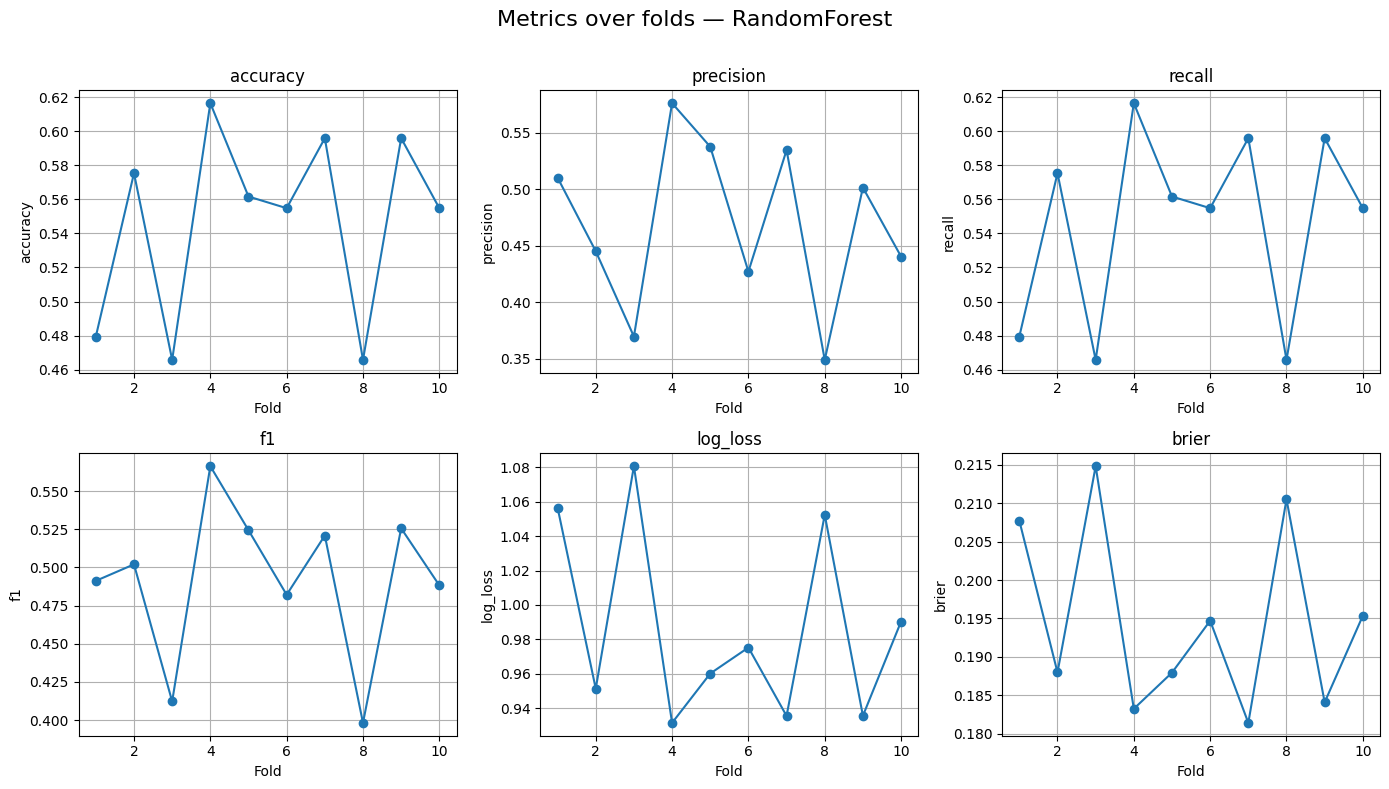

In [20]:
import matplotlib.pyplot as plt

def plot_metrics_over_folds(results_dict, model_name="RandomForest"):
    df = pd.DataFrame(results_dict)
    folds = range(1, len(df) + 1)

    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(df.columns):
        plt.subplot(2, 3, i + 1)
        plt.plot(folds, df[metric], marker='o')
        plt.title(metric)
        plt.xlabel("Fold")
        plt.ylabel(metric)
        plt.grid(True)

    plt.suptitle(f"Metrics over folds — {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Use it:
plot_metrics_over_folds(results["RandomForest"], "RandomForest")


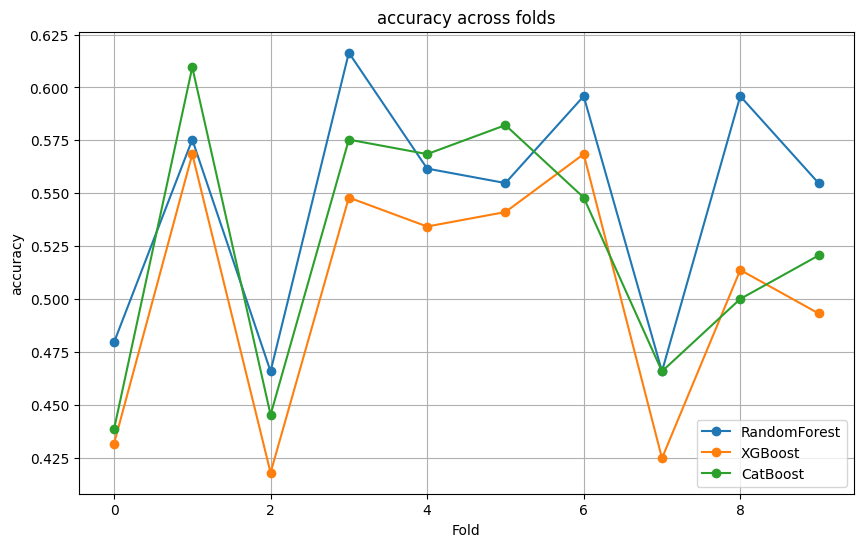

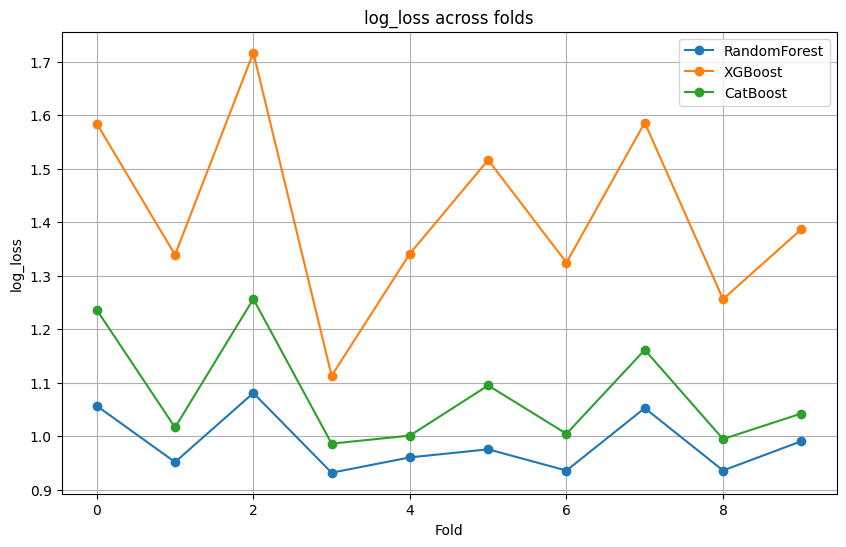

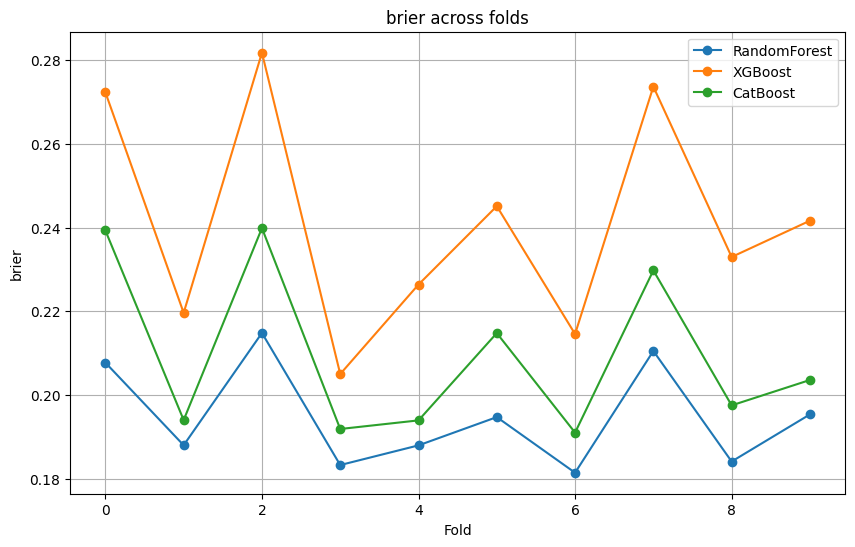

In [21]:
def compare_models_metrics(results, metric):
    plt.figure(figsize=(10,6))

    for model_name, model_results in results.items():
        df = pd.DataFrame(model_results)
        plt.plot(df[metric], marker='o', label=model_name)

    plt.title(f"{metric} across folds")
    plt.xlabel("Fold")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

compare_models_metrics(results, "accuracy")
compare_models_metrics(results, "log_loss")
compare_models_metrics(results, "brier")


In [11]:
rf = RandomForestClassifier(
    n_estimators=1500,
    max_depth=12,
    min_samples_split=4,
    random_state=42
)

In [12]:
from sklearn.calibration import CalibratedClassifierCV

final_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
final_rf.fit(X, y)

,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,1500
,criterion,'gini'
,max_depth,12
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [13]:
# Predictions on training set
train_preds = final_rf.predict(X)

# Training accuracy
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)

train_probs = final_rf.predict_proba(X)

print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))


Training accuracy: 0.9651307596513076
Training precision: 0.9668648607363375
Training recall: 0.9651307596513076
Training f1: 0.9652035749111982
Training log loss: 0.44590398874569825


In [20]:
import joblib
joblib.dump(final_rf, "../../models/random_forest_model.pkl", compress=3)

feature_names = X.columns.tolist()
features_path = '../../models/feature_names.pkl'
joblib.dump(feature_names, features_path, compress=3)

['../../models/feature_names.pkl']

In [17]:
# --- 2. XGBoost ---
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    tree_method='hist'
)

# --- 3. CatBoost ---
cat = CatBoostClassifier(
    loss_function='MultiClass',
    depth=7,
    iterations=1500,
    learning_rate=0.03,
    verbose=False
)

In [18]:
final_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
final_xgb.fit(X, y)

,estimator,"XGBClassifier..._class=3, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [21]:
# Predictions on training set
train_preds = final_xgb.predict(X)

# Training accuracy
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)

train_probs = final_xgb.predict_proba(X)

print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))
joblib.dump(final_xgb, "../../models/xgboost_model.pkl", compress=3)

Training accuracy: 1.0
Training precision: 1.0
Training recall: 1.0
Training f1: 1.0
Training log loss: 0.3504173138596078


['../../models/xgboost_model.pkl']

In [22]:
final_cat = CalibratedClassifierCV(cat, method='isotonic', cv=5)
final_cat.fit(X, y)

,estimator,<catboost.cor...t 0x1074b5e80>
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'


In [23]:
train_preds = final_cat.predict(X)
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)
train_probs = final_cat.predict_proba(X)
print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))
joblib.dump(final_cat, "../../models/catboost_model.pkl", compress=3)

Training accuracy: 0.9975093399750934
Training precision: 0.9975231386455916
Training recall: 0.9975093399750934
Training f1: 0.9975099074050302
Training log loss: 0.44615372137145354


['../../models/catboost_model.pkl']

In [33]:
from sklearn.calibration import calibration_curve

def plot_calibration(model, X_test, y_test, class_index, class_name):
    probs = model.predict_proba(X_test)[:, class_index]
    true_labels = (y_test == class_index).astype(int)

    prob_true, prob_pred = calibration_curve(true_labels, probs, n_bins=10)

    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f"Calibration Curve: {class_name}")
    plt.xlabel("Predicted probability")
    plt.ylabel("True probability")
    plt.show()

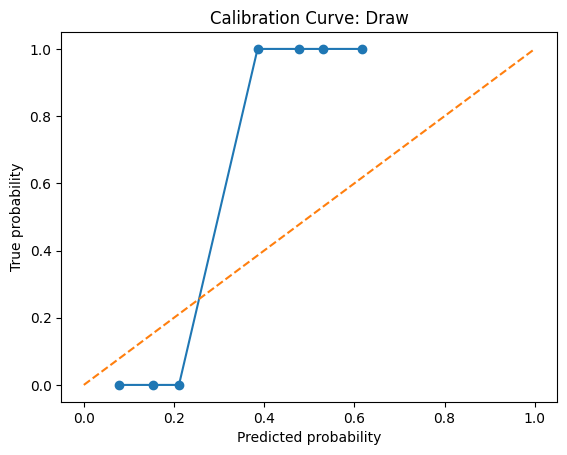

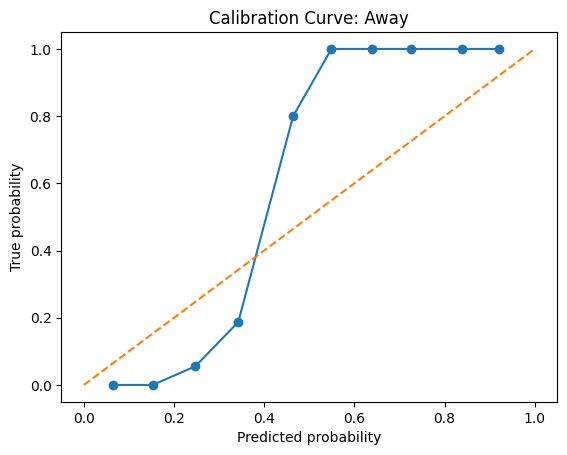

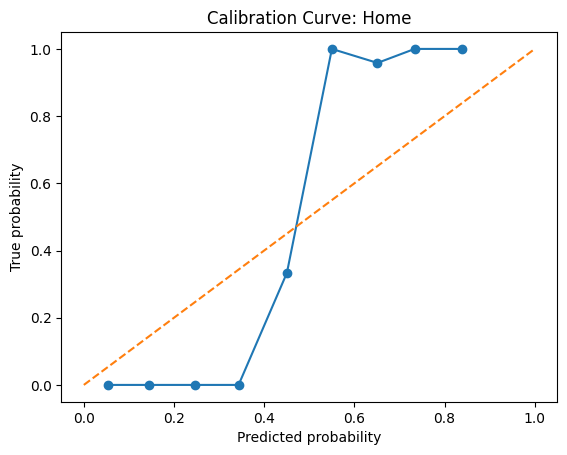

In [34]:
plot_calibration(final_rf, X_test, y_test, 0, "Draw")
plot_calibration(final_rf, X_test, y_test, 1, "Away")
plot_calibration(final_rf, X_test, y_test, 2, "Home")

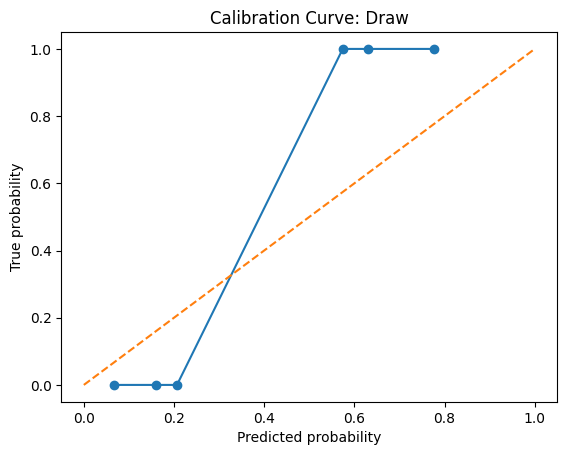

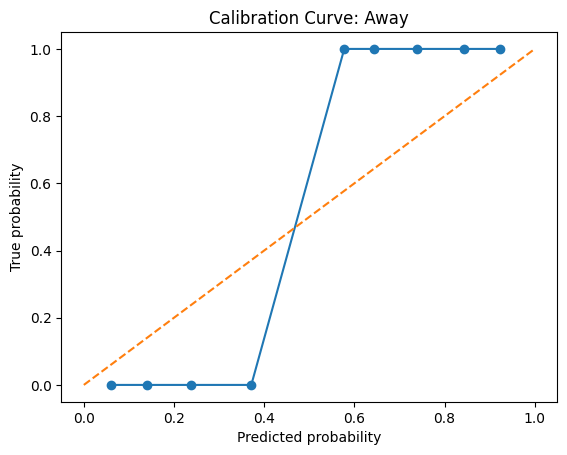

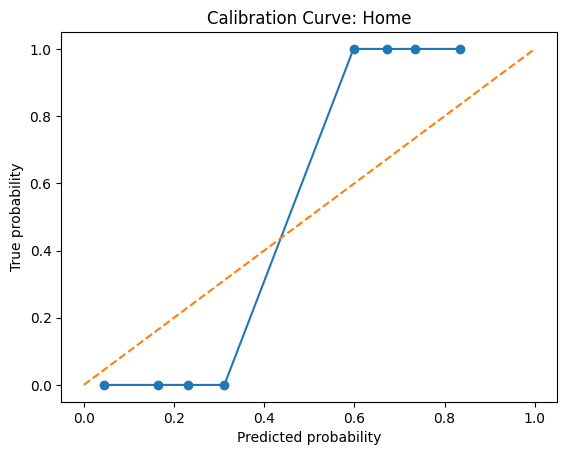

In [35]:
plot_calibration(final_xgb, X_test, y_test, 0, "Draw")
plot_calibration(final_xgb, X_test, y_test, 1, "Away")
plot_calibration(final_xgb, X_test, y_test, 2, "Home")

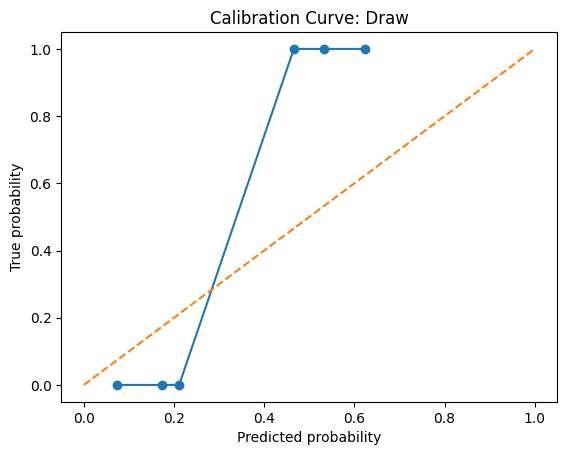

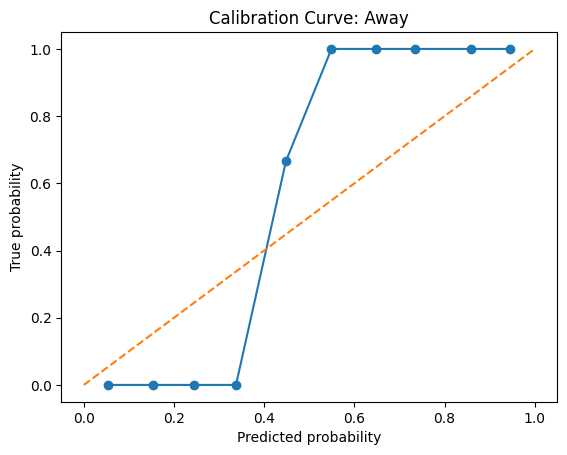

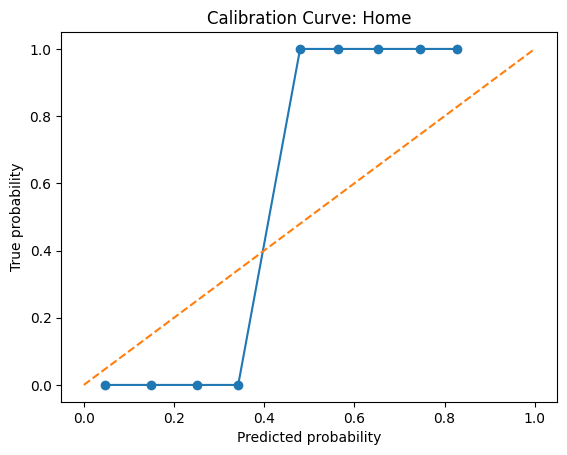

In [36]:
plot_calibration(final_cat, X_test, y_test, 0, "Draw")
plot_calibration(final_cat, X_test, y_test, 1, "Away")
plot_calibration(final_cat, X_test, y_test, 2, "Home")